# Car Insurance Fraud Claim Detection

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from mlxtend.plotting import plot_confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, accuracy_score, recall_score, roc_curve, precision_recall_curve, auc
from sklearn.tree import DecisionTreeClassifier
import warnings

In [32]:
np.random.seed(1)

warnings.filterwarnings("ignore")

data = pd.read_csv("insurance_claims.csv")

drop_columns = ["_c39", "auto_model", "policy_bind_date", "policy_state", "incident_date",
               "incident_state", "incident_city", "incident_location", "policy_csl"]

data = data.drop(drop_columns, axis=1)

new_response = []
response = data.iloc[:, -1]
for i in range(len(response)):
    new_response.append(1 if response[i]=='Y' else 0)

data["fraud_reported"] = pd.Series(new_response)

We will be dropping insignificant features like: 

- policy_bind_date
- policy_state
- incident_date
- auto_model
- _c39
- policy_csl

# Performing initial EDA.

Text(0, 0.5, 'Number of customers')

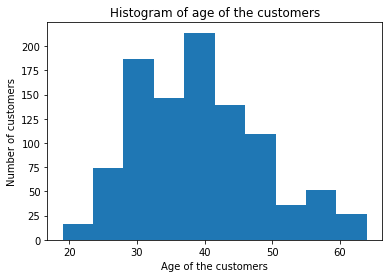

In [33]:
plt.hist(data.age)
plt.title("Histogram of age of the customers")
plt.xlabel("Age of the customers")
plt.ylabel("Number of customers")

Text(0, 0.5, 'Number of customers')

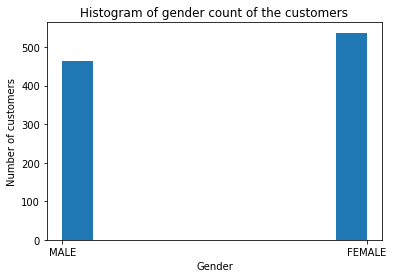

In [34]:
plt.hist(data.insured_sex)
plt.title("Histogram of gender count of the customers")
plt.xlabel("Gender")
plt.ylabel("Number of customers")

- We can see that male and female are almost in the same proportion.

Text(0, 0.5, 'Number of responses')

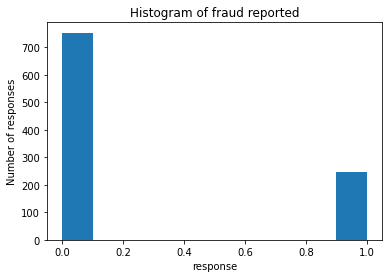

In [35]:
plt.hist(data.fraud_reported)
plt.title("Histogram of fraud reported")
plt.xlabel("response")
plt.ylabel("Number of responses")

- We can also see that there is a significant class imbalance, we will be using SMOTE, Synthetic Minority Oversampling Technique to add additional minority class data points.

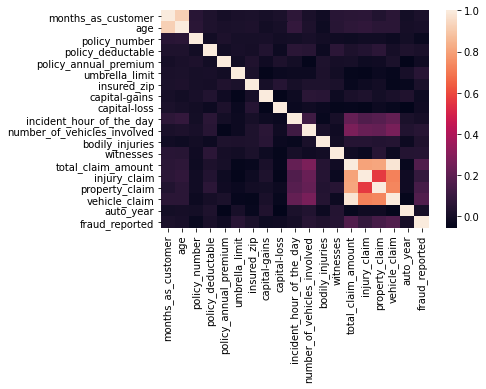

In [36]:
sns.heatmap(data.corr())
plt.show()

In [37]:
predictors = data.iloc[:,:-1]
response = data.iloc[:, -1]

# new_response = []

# for i in range(len(response)):
#     new_response.append(1 if response[i]=='Y' else 0)
    
# response = pd.Series(new_response)

categorical_data = predictors.select_dtypes(exclude="number")
categorical_predictors = categorical_data.columns

predictors = predictors.drop(categorical_predictors, axis=1)

- Since most of our data is categorical we have two options, assign a integer value to each level of the categorical variable or one-hot encode these categorical variables. 

- One major drawback of assigning integer value to each level is that it adds additional charecteristics to the data. For example let's say we have a variable with levels as BMW, Mazda, Mercedes and Subaru and we are assigning 0, 1, 2 and 3 integer values to them respectively. When we apply any model the model considers these values as continuous and assumes an unwanted hierarchy like BMQ < Mazda < Mercedes < Subaru, which might not be the case at all.

- Hence we go with one hot encoding of categorical variables. 

In [38]:
one_hot_data = pd.get_dummies(categorical_data)
predictors = predictors.join(one_hot_data)

predictor_columns = predictors.columns
response_columns = response

predictors_train, predictors_test, response_train, response_test = train_test_split(predictors,
                                                                                    response,
                                                                                    test_size=0.3)

- Since we have class imbalance in the data, we perform minority class oversampling using SMOTE, Synthetic Minority Oversampling Technique, which uses K nearest neighbors to come up with new samples in the minority class.

In [39]:
sm = SMOTE(random_state=24)
predictors, response = sm.fit_resample(predictors_train, response_train)

predictors_train = pd.DataFrame(predictors, columns=predictor_columns)
response_train = pd.Series(response)

model_preds = {}

# Logistic Regression

*****************************************
Results on testing data:
*****************************************
Accuracy = 0.5566666666666666
Precision = 0.625
Recall = 0.32679738562091504

AUC value = 0.5613578764839269


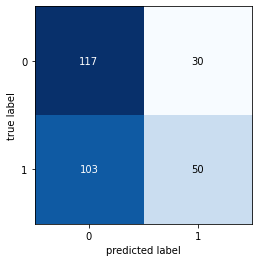

In [40]:
model = LogisticRegression()
model.fit(predictors_train, response_train)
predictions_test = model.predict(predictors_test)
predictions_train = model.predict(predictors_train)

conf_matrix = confusion_matrix(predictions_test, response_test)
plot_confusion_matrix(conf_matrix)

precision = precision_score(predictions_test, response_test)
recall = recall_score(predictions_test, response_test)

print("*****************************************")
print("Results on testing data:")
print("*****************************************")
print("Accuracy = "+str(accuracy_score(predictions_test, response_test)))
print("Precision = "+str(precision))
print("Recall = "+str(recall))

tpr, fpr, threshold = roc_curve(predictions_test, response_test, pos_label=1)
model_preds["Logistic Regression"] = [tpr, fpr]
print()
print("AUC value = "+str(auc(tpr, fpr)))

# K Nearest Neighbors

*****************************************
Results on testing data:
*****************************************
Accuracy = 0.54
Precision = 0.45
Recall = 0.27692307692307694

AUC value = 0.5090497737556561


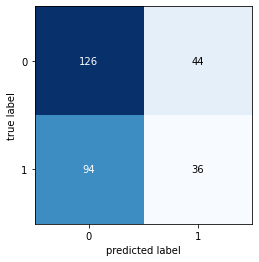

In [41]:
knn = KNeighborsClassifier()
knn.fit(predictors_train, response_train)

predictions_train = knn.predict(predictors_train)
predictions_test = knn.predict(predictors_test)

conf_matrix = confusion_matrix(predictions_test, response_test)
plot_confusion_matrix(conf_matrix)

precision = precision_score(predictions_test, response_test)
recall = recall_score(predictions_test, response_test)

print("*****************************************")
print("Results on testing data:")
print("*****************************************")
print("Accuracy = "+str(accuracy_score(predictions_test, response_test)))
print("Precision = "+str(precision))
print("Recall = "+str(recall))

tpr, fpr, threshold = roc_curve(predictions_test, response_test, pos_label=1)
model_preds["K Nearest Neighbor"] = [tpr, fpr]
print()
print("AUC value = "+str(auc(tpr, fpr)))

# Decision Trees

*****************************************
Results on testing data:
*****************************************
Accuracy = 0.85
Precision = 0.8862275449101796
Recall = 0.8361581920903954

AUC value = 0.8516455296116312


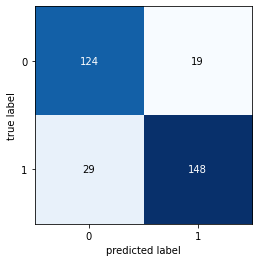

In [42]:
## Since it has a lot of categorical variables and the dataset is also not huge we 
## will use decision trees to get more accuracy.

predictors_train, predictors_test, response_train, response_test = train_test_split(predictors,response,test_size=0.3)

tree = DecisionTreeClassifier()
tree.fit(predictors_train, response_train)
predictions_test = tree.predict(predictors_test)
predictions_train = tree.predict(predictors_train)

conf_matrix = confusion_matrix(predictions_test, response_test)
plot_confusion_matrix(conf_matrix)

precision = precision_score(predictions_test, response_test)
recall = recall_score(predictions_test, response_test)

print("*****************************************")
print("Results on testing data:")
print("*****************************************")
print("Accuracy = "+str(accuracy_score(predictions_test, response_test)))
print("Precision = "+str(precision))
print("Recall = "+str(recall))

tpr, fpr, threshold = roc_curve(predictions_test, response_test, pos_label=1)
model_preds["Decision Tree"] = [tpr, fpr]
print()
print("AUC value = "+str(auc(tpr, fpr)))

# Random Forest Classifier

*****************************************
Results on testing data:
*****************************************
Accuracy = 0.8875
Precision = 0.8922155688622755
Recall = 0.8922155688622755

AUC value = 0.887284255019373


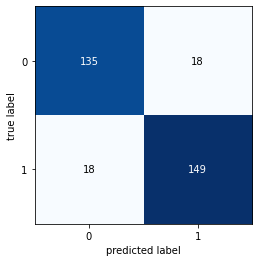

In [43]:
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier()
random_forest.fit(predictors_train, response_train)
predictions_test = random_forest.predict(predictors_test)
predictions_train = random_forest.predict(predictors_train)

conf_matrix = confusion_matrix(predictions_test, response_test)
plot_confusion_matrix(conf_matrix)

precision = precision_score(predictions_test, response_test)
recall = recall_score(predictions_test, response_test)

print("*****************************************")
print("Results on testing data:")
print("*****************************************")
print("Accuracy = "+str(accuracy_score(predictions_test, response_test)))
print("Precision = "+str(precision))
print("Recall = "+str(recall))

tpr, fpr, threshold = roc_curve(predictions_test, response_test, pos_label=1)
model_preds["Random Forest"] = [tpr, fpr]
print()
print("AUC value = "+str(auc(tpr, fpr)))

# Receiving Operator Charecteristic

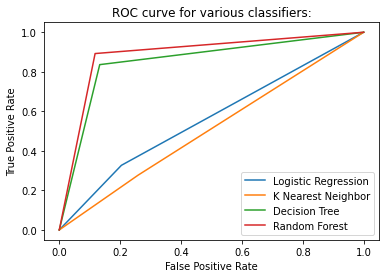

In [44]:
plt.title("ROC curve for various classifiers:")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

for key, value in model_preds.items():
    model_list = model_preds[key]
    plt.plot(model_list[0], model_list[1], label=key)
    plt.legend()
plt.show()

- As we can see from the above ROC curves and results random forest is performing well when compared to all the classifiers.
- KNN is performing the worst out of all the classifiers.
- I was hoping to get better results with Random Forests but with this size of the data I am not surprised with this result. 